In [17]:
%reset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import math 
import os
import random
import copy
import networkx as nx
import time
np.random.seed(3210)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [18]:
# RANDOM GRAPH GENERATION

def Flip(p):
    return np.random.binomial(1,p)

#%% Create connected graph with N vertices and E edges with weights between p_min and p_max
def generateRandomGraph(N, E, p_min, p_max, typ = 'gnp', degree = 3):
    
    if typ == 'rndc':
        return generateRandomConnectedGraph(N, E, p_min, p_max)
    else:
        return generateFromNx(N, p_min, p_max, typ, degree)

    
            
def generateFromNx(N, p_min, p_max, typ = 'gnp', degree = 3):
    min_degree = 0
    count = 0
    
    while min_degree < 3:
        # substitute gnp_random_graph with diff func and appropriate params
        # to generate different type of graphs 
        if typ == 'gnp':
            G  = nx.gnp_random_graph(N,1.0/np.sqrt(N), directed =False)
        if typ == 'reg':
            G = nx.random_regular_graph(degree, N)
        
        min_degree = min([d[1] for d in G.degree()])
        count += 1
        if count == 100:
            print('Failure')
            return None
    
    edges = G.edges()
    true_weights = np.zeros((N,N))
    for e in edges:
        u,v = e
        wgt = np.random.uniform(low = p_min, high=p_max)
        true_weights[u][v] = true_weights[v][u] = wgt
    print ('Total Edges', len(edges()))
    print ('Degrees', G.degree())
    print ('Min Degrees', min_degree)
    return true_weights

def generateRandomConnectedGraph(N, E, p_min, p_max):
    initialSet = set()
    visitedSet = set()
    vertices = set()
    true_weights = np.zeros((N,N))
    #generate the set of names for the vertices
    for i in range(N):
        initialSet.add(i)
        vertices.add(i)
    #set the intial vertex to be connected
    curVertex = random.sample(initialSet, 1).pop()
    initialSet.remove(curVertex)
    visitedSet.add(curVertex)
    #loop through all the vertices, connecting them randomly
    while initialSet:
        adjVertex = random.sample(initialSet, 1).pop()
        true_weights[curVertex, adjVertex] = true_weights[adjVertex, curVertex] = np.random.uniform(low = p_min, high=p_max)
        initialSet.remove(adjVertex)
        visitedSet.add(adjVertex)
        curVertex = adjVertex
    while E > N - 1:
        firstVertex = np.random.randint(0, N)
        secondVertex = np.random.randint(0, N)
        if firstVertex != secondVertex:
            if true_weights[firstVertex, secondVertex] == 0:
                true_weights[firstVertex, secondVertex] = true_weights[secondVertex, firstVertex] = np.random.uniform(low = p_min, high=p_max)
                E -= 1
    return true_weights
  

In [19]:
# CASCADE GENERATION

def Cascade(weights, stop_early=True):
    """ times_infection vector of size N """
    (N, _) = np.shape(weights) 
    source = np.random.randint(N)    
    infectedSet = set()
    infectedSet.add(source)
    susceptibleSet = set(range(N))
    susceptibleSet.remove(source)
    t = 0
    infections = {'start': source}
    while len(infectedSet) > 0:
        t += 1
        if t > 2 and stop_early:
            # Our algo only need the infections during the first 2 time steps, 
            # so we don't compute the rest of the cascade
            return infections
        infectedNew = set()
        for infectedVertex in infectedSet:
            infections[infectedVertex] = set()
            for susceptibleVertex in susceptibleSet:
                if Flip(weights[infectedVertex, susceptibleVertex]):
                    infectedNew.add(susceptibleVertex)
                    infections[infectedVertex].add(susceptibleVertex)
        infectedSet.clear()
        infectedSet.update(infectedNew)
        susceptibleSet.difference_update(infectedSet)
    return infections
    
def Mixture(weights1, weights2, alpha=0.5, stop_early=True):
    if Flip(alpha):
        return Cascade(weights1, stop_early), 1
    else:
        return Cascade(weights2, stop_early), 2

def MultipleCascades(weights, n_cascades, stop_early=True):
    mat_cascades = []
    for i_cascade in range(n_cascades):
        if ((i_cascade % 100000) == 0):
            print "cascade", i_cascade
        infections= Cascade(weights, stop_early)
        mat_cascades.append(infections)
    return mat_cascades

def MultipleCascadesOnMixture(weights1, weights2, n_cascades, alpha=0.5, stop_early=True, debug=False):
    mat_cascades = []
    mixture = []
    for i_cascade in range(n_cascades):
        if (debug and ((i_cascade % 100000) == 0)):
            print "cascade", i_cascade
        infections, mix = Mixture(weights1, weights2, alpha, stop_early)
        mat_cascades.append(infections)
        mixture.append(mix)
    return mat_cascades, mixture

In [20]:
# COMPUTE EXPECTATION OF ESTIMATORS

def getTrueValue(N, weights1, weights2):
    X = (weights1 + weights2)/2
    Y = np.zeros((N,N,N))
    for i in xrange(N):
        for j in xrange(N):
            for k in xrange(N):
                if j != k and j!= i:
                    Y[i,j,k] = (weights1[i,j]*weights1[i,k] \
                                + weights2[i,j]*weights2[i,k])/2
    return X, Y

In [21]:
# COMPUTE ESTIMATORS

def getEstimators(N, cascades, X0 = None, Y0 = None, count0 = None):
    X = np.zeros((N,N))
    Y = np.zeros((N,N,N))
    if (X0 is None) or (Y0 is None) or (count0 is None):
        count = np.zeros(N) 
    else:
        count = copy.deepcopy(count0)
        for i in range(N):
            X[i,:] = X0[i,:] * float(count[i])  
            Y[i,:,:] = Y0[i,:,:] * float(count[i])

    
    for cascade in cascades:
        source = cascade['start']
        count[source] += 1
        for a in cascade[source]:
            X[source, a] += 1
            for b in cascade[source]:
                if a != b:
                    Y[source, a, b] += 1
    count[count==0] = 1.
    
     
    for i in range(N):
        X[i,:] /= float(count[i])  
        Y[i,:,:] /= float(count[i]) 
        
    return X, Y, count
    

In [22]:
# PRELIMINARY FUNCTIONS

def learnEdges(X):
    edges = (X > 0).astype(int)
    return edges

def createNeighbors(N, edges):
    neighbors = []; degrees = []
    for i in range(N):
        neighbors.append([j for j in range(N) if edges[i,j] == 1 or edges[j,i] == 1])
        degrees.append(len(neighbors[i]))
    return neighbors, degrees 

In [23]:
# LEARN WEIGTHS OF STAR NODES 

def learnStarEdge(u, a, b, c, s, X, Y):
    val = (Y[u,a,b] - X[u,a]*X[u,b])* (Y[u,a,c] - X[u,a]*X[u,c])/(Y[u,b,c] - X[u,b]*X[u,c])
    val = max(0, val)
    p = min(1, X[u,a] + s * math.sqrt(val))
    q = min(1, X[u,a] - s * math.sqrt(val))
    return p, q

def learnStarNode(u, a, neighbors, X, Y, weightsP, weightsQ, signs):
    rel_neighbors = [i for i in neighbors[u] if i!=a]
    num_neighbors = len(rel_neighbors)
    s = signs[u][a]
    (weightsP[u][a], weightsQ[u][a]) = learnStarEdge(u, a, rel_neighbors[0], rel_neighbors[1], s, X, Y)
    for i in range(num_neighbors):
        b = rel_neighbors[i]
        c = rel_neighbors[(i+1)%num_neighbors]
        sb = s * np.sign(Y[u,a,b] - X[u,a]*X[u,b])
        signs[u][b] = sb
        signs[b][u] = sb
        (weightsP[u][b], weightsQ[u][b]) = learnStarEdge(u, b, a, c, sb, X, Y)
      

In [24]:
# LEARN THE WHOLE WEIGHTED GRAPH

def learnGraph(N, X, Y):
    edges = learnEdges(X)
    (neighbors, degrees) = createNeighbors(N, edges)
    #   print degrees
    weightsP = np.zeros((N,N))
    weightsQ = np.zeros((N,N))
    signs = np.zeros((N,N))
    if 2 in degrees:
        print "Not Learning This Graph. HAS degree 2 NODE"
    else:
        order = np.argsort(degrees)
        index = 0
        explored = set()
        # keep track of nodes to be checked
        queue = [(order[0], -1)]
        # keep looping until there are nodes still to be checked
        while queue:
            # pop shallowest node (first node) from queue
            node, anchor = queue.pop(0)
            if node not in explored:
                # add node to list of checked nodes
                explored.add(node)
                if degrees[node] > 1:
                    if anchor < 0:
                        anchor = neighbors[node][0]
                        signs[node, anchor] = 1
                        signs[anchor, node] = 1
                    learnStarNode(node, anchor, neighbors, X, Y, weightsP, weightsQ, signs)

                    adjacent = neighbors[node]
                    for neighbour in adjacent:
                        queue.append((neighbour, node))
    return weightsP, weightsQ

In [25]:
# CREATE ONE RANDOM GRAPH

def createGraph(
    numVertices = 10,
    density = 0.75,
    pMinA = 0.8,
    pMaxA = 0.9,
    pMinB = 0.4,
    pMaxB = 0.5,
    typ = 'gnp',
    degree = 3
):
    numEdges = int(density*0.5*numVertices*(numVertices-1))
    weightsA = generateRandomGraph(numVertices, numEdges, pMinA, pMaxA, typ, degree)
    weightsB = generateRandomGraph(numVertices, numEdges, pMinB, pMaxB, typ, degree)
    return weightsA, weightsB

In [26]:
# SIMULATE MANY CASCADES ON A GIVEN GRAPH

tolerance = 0.2

def simulate(
    weightsA, 
    weightsB,
    numCascades_step = 10000,
    numCascades_mult = 20,
    numPath = 30,
    verbose = True
):
    avg_E_error = [[] for _ in range(numPath)]
    avg_NE_error = [[] for _ in range(numPath)]
    max_error = [[] for _ in range(numPath)]
    final_errors = []
    
    
    numVertices = weightsA.shape[0]
    edges_A = [(i,j) for i in range(numVertices) for j in range(numVertices)
                                    if weightsA[i, j] > tolerance ]
    nonedges_A = [(i,j) for i in range(numVertices) for j in range(numVertices)
                                    if weightsA[i, j] <= tolerance ]
    
    edges_B = [(i,j) for i in range(numVertices) for j in range(numVertices)
                                    if weightsB[i, j] > tolerance ]
    nonedges_B = [(i,j) for i in range(numVertices) for j in range(numVertices)
                                    if weightsB[i, j] <= tolerance ]
    
    if verbose:
        print "numVertices", numVertices, 
        print "numEdges A", len(edges_A), 
        print "numEdges B", len(edges_B)
    
    X_true, Y_true = getTrueValue(numVertices, weightsA, weightsB)
    
    for r in range(numPath):
        numCascades = 0
        X_est, Y_est, count_est = None , None, None
        
        if verbose:
            print "numpath", (r+1)
        
        for _ in range(numCascades_mult):
            numCascades += numCascades_step
            
            cascadesM, mixM = MultipleCascadesOnMixture(weightsA, weightsB, 
                                                        numCascades_step)
            
            X_est, Y_est, count_est = getEstimators(numVertices, cascadesM, 
                                         X0=X_est, Y0=Y_est, count0=count_est)
            
           
            
            weightsA_est, weightsB_est = learnGraph(numVertices, X_est, Y_est)
            
            diff_1_A = np.absolute(weightsA_est - weightsA)
            diff_1_B = np.absolute(weightsB_est - weightsB)
            diff_2_A = np.absolute(weightsB_est - weightsA)
            diff_2_B = np.absolute(weightsA_est - weightsB)
            
            max_error_1_A = np.max(diff_1_A)
            max_error_1_B = np.max(diff_1_B)

            max_error_2_A = np.max(diff_2_A)
            max_error_2_B = np.max(diff_2_B)
            
            tot_error_1_AE = np.sum([diff_1_A[i,j] 
                                    for i, j in edges_A])
            tot_error_1_BE = np.sum([diff_1_B[i,j]  
                                    for i, j in edges_B])
            
            tot_error_2_AE = np.sum([diff_2_A[i,j] 
                                    for i, j in edges_A])
            tot_error_2_BE = np.sum([diff_2_B[i,j]  
                                    for i, j in edges_B])
            
            tot_error_1_ANE = np.sum([diff_1_A[i,j] 
                                    for i, j in nonedges_A])
            tot_error_1_BNE = np.sum([diff_1_B[i,j] 
                                    for i, j in nonedges_B])
            
            tot_error_2_ANE = np.sum([diff_2_A[i,j] 
                                    for i, j in nonedges_A])
            tot_error_2_BNE = np.sum([diff_2_B[i,j] 
                                    for i, j in nonedges_B])
            
            max_error_A = max_error_1_A
            max_error_B = max_error_1_B
            tot_error_AE = tot_error_1_AE
            tot_error_BE = tot_error_1_BE
            tot_error_ANE = tot_error_1_ANE
            tot_error_BNE = tot_error_1_BNE

            if tot_error_AE + tot_error_BE > tot_error_2_AE + tot_error_2_BE:
                max_error_A = max_error_2_A
                max_error_B = max_error_2_B
                tot_error_AE = tot_error_2_AE
                tot_error_BE = tot_error_2_BE
                tot_error_ANE = tot_error_2_ANE
                tot_error_BNE = tot_error_2_BNE

            max_err = np.max([max_error_A, max_error_B], axis = 0)
            avg_err_E = (tot_error_AE + tot_error_BE)/(len(edges_A) + len(edges_B))
            avg_err_NE = (tot_error_ANE + tot_error_BNE)/(len(nonedges_A) + len(nonedges_B))
            
            if verbose:
                print "#", numCascades, 
                print "max X ", np.round(np.max(np.absolute(X_est - X_true)),3),
                print "max Y ", np.round(np.max(np.absolute(Y_est - Y_true)), 3),
                print "max ", np.round(max_err,3),
                print "avg edge ", np.round(avg_err_E,3),
                print "avg nonedge ", np.round(avg_err_NE,3)
            
            
            max_error[r].append(max_err)
            avg_E_error[r].append(avg_err_E)
            avg_NE_error[r].append(avg_err_NE)

            
        final_errors.extend(np.absolute(weightsA_est - weightsA))
        final_errors.extend(np.absolute(weightsB_est - weightsB))
        
    results = {
        'avgE': avg_E_error,
        'avgNE': avg_NE_error,
        'max': max_error,
        'hist': np.histogram(final_errors, bins = 100)
    }
    return results

In [27]:
# EXPERIMENTS FUNCTIONS

def fun(res, attr):
    y0 = np.mean(res[attr], axis=0)
    y1 = np.percentile(res[attr], 75, axis=0)
    y2 = np.percentile(res[attr], 25, axis=0)
    return y0, y1, y2


def plotExp1(results, numV, typ,  numCascades_step = int(10e3), numCascades_mult = 10):
    x_axis = numCascades_step*np.arange(1, numCascades_mult+1)
    m0, m1, m2 = fun(results, attr= 'max')
    a0, a1, a2 = fun(results, attr= 'avgE')
    na0, na1, na2 = fun(results, attr= 'avgNE')
    
    plt.figure()
    plt.plot(x_axis, m0, '.-', label = 'Max error')
    plt.fill_between(x_axis, m1, m2, alpha=0.4)
    
    plt.plot(x_axis, a0, 's-', label = 'Avg Edge error')
    plt.fill_between(x_axis, a1, a2, alpha=0.4)
    
    plt.plot(x_axis, na0, 'o-', label = 'Avg Non-Edge error')
    plt.fill_between(x_axis, na1, na2, alpha=0.4)

    plt.legend(fontsize=15)
    plt.xlabel('Number of Samples: '+ str(numV) +' vertices', fontsize=20)
    plt.ylabel('Error', fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=12)
    plt.savefig('./Results/decay'+ typ + str(int(numV))+'.pdf', format='pdf', bbox_inches = "tight")
    plt.show()
    plt.close()
    
def plotExp2(results, numV, typ,
             numCascades_step = int(10e3), numCascades_mult = 10):
    x_axis = range(1, numCascades_mult+1)
    hist, bins = results['hist']
    hist = hist/float(sum(hist))
    hist = hist[1:]
    bins = bins[1:]
    plt.figure()
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel('Error on Edge: '+ str(numV) + ' vertices', fontsize=20)
    plt.ylabel('Probability', fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('./Results/hist'+ typ + str(int(numV)) +'.pdf', format='pdf', bbox_inches = "tight")
    plt.show()
    plt.close()
    
    
def plotExp3(err_dict, N, typ, scale, error_tol):
    """
    err_dict: error dictionary for different vertices
    typ: typer of graph
    scale: scale of search: searching parameter
    err_tol: error tolerance (one curve for each level)
    """
    
    numDegree = sorted(err_dict.keys())
    sample_req = np.zeros((len(numDegree), len(error_tol), 3)) #  [mean, 75, 25]
    
    print "numDegree", numDegree
    
    for i, numD in enumerate(numDegree): 
        results = err_dict[numD] 
        print 'numD', numD, 'Final error', [np.round(res[-1],2) for res in results['max']]
        for j,tol in enumerate(error_tol):
            arr = []
            for err in results['max']: # sample path
                if np.searchsorted(err[::-1], tol):
                    arr.append(len(err)- np.searchsorted(err[::-1], tol))
            sample_req[i][j] = [1000*N*np.mean(arr), 1000*N*np.percentile(arr,75), 
                                1000*N*np.percentile(arr, 25)] 
        
    sample_req = sample_req
    print sample_req
    
    plt.figure()
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    for i,tol in enumerate(error_tol):
        print 'tol', tol, 'mean', sample_req[:,i,0], 
        print '75 per', sample_req[:,i,1],  
        print '25 per', sample_req[:,i,2]
        plt.plot(numDegree, sample_req[:,i,0], '-*', label = 'error '+str(np.round(tol,3)))
        plt.fill_between(numDegree, sample_req[:,i,1], sample_req[:,i,2], alpha=0.2)
    
    plt.legend(loc = 'upper left', fontsize = 15)
    plt.xlabel("Degree", fontsize = 18)
    plt.ylabel("Number of samples" , fontsize = 20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig('./Results/' + typ + '_degree.pdf', format='pdf', bbox_inches = "tight")

In [28]:
# EXPERIMENT 1: 
# Comparison of max and average error

N = 20
numCascades_step = N*100 
numCascades_mult = 15
numPath = 10
weightsA, weightsB = createGraph(N, typ = 'gnp')

('Total Edges', 54)
('Degrees', DegreeView({0: 9, 1: 6, 2: 5, 3: 3, 4: 4, 5: 4, 6: 8, 7: 4, 8: 4, 9: 8, 10: 4, 11: 4, 12: 5, 13: 7, 14: 8, 15: 4, 16: 5, 17: 4, 18: 6, 19: 6}))
('Min Degrees', 3)
('Total Edges', 47)
('Degrees', DegreeView({0: 3, 1: 6, 2: 6, 3: 5, 4: 4, 5: 7, 6: 3, 7: 5, 8: 3, 9: 5, 10: 3, 11: 5, 12: 10, 13: 4, 14: 6, 15: 4, 16: 5, 17: 4, 18: 3, 19: 3}))
('Min Degrees', 3)


numVertices 20 numEdges A 108 numEdges B 94
numpath 1
# 2000 max X  0.12 max Y  0.097 max  0.376 avg edge  0.067 avg nonedge  0.012
# 4000 max X  0.079 max Y  0.086 max  0.239 avg edge  0.045 avg nonedge  0.007
# 6000 max X  0.064 max Y  0.072 max  0.119 avg edge  0.037 avg nonedge  0.006
# 8000 max X  0.059 max Y  0.06 max  0.118 avg edge  0.032 avg nonedge  0.005
# 10000 max X  0.048 max Y  0.049 max  0.193 avg edge  0.028 avg nonedge  0.005
# 12000 max X  0.046 max Y  0.045 max  0.165 avg edge  0.027 avg nonedge  0.005
# 14000 max X  0.045 max Y  0.047 max  0.14 avg edge  0.026 avg nonedge  0.004
# 16000 max X  0.04 max Y  0.04 max  0.101 avg edge  0.024 avg nonedge  0.004
# 18000 max X  0.04 max Y  0.04 max  0.1 avg edge  0.021 avg nonedge  0.003
# 20000 max X  0.037 max Y  0.04 max  0.086 avg edge  0.019 avg nonedge  0.003
# 22000 max X  0.032 max Y  0.036 max  0.085 avg edge  0.018 avg nonedge  0.003
# 24000 max X  0.031 max Y  0.036 max  0.066 avg edge  0.018 avg nonedge  0.003


# 26000 max X  0.039 max Y  0.026 max  0.072 avg edge  0.017 avg nonedge  0.002
# 28000 max X  0.044 max Y  0.032 max  0.072 avg edge  0.016 avg nonedge  0.002
# 30000 max X  0.04 max Y  0.026 max  0.063 avg edge  0.015 avg nonedge  0.002
numpath 8
# 2000 max X  0.148 max Y  0.141 max  0.308 avg edge  0.074 avg nonedge  0.011
# 4000 max X  0.086 max Y  0.112 max  0.742 avg edge  0.05 avg nonedge  0.008
# 6000 max X  0.078 max Y  0.09 max  0.17 avg edge  0.037 avg nonedge  0.005
# 8000 max X  0.063 max Y  0.082 max  0.125 avg edge  0.031 avg nonedge  0.005
# 10000 max X  0.065 max Y  0.068 max  0.129 avg edge  0.03 avg nonedge  0.004
# 12000 max X  0.051 max Y  0.069 max  0.145 avg edge  0.028 avg nonedge  0.004
# 14000 max X  0.059 max Y  0.073 max  0.142 avg edge  0.026 avg nonedge  0.004
# 16000 max X  0.051 max Y  0.065 max  0.132 avg edge  0.024 avg nonedge  0.004
# 18000 max X  0.047 max Y  0.059 max  0.1 avg edge  0.023 avg nonedge  0.004
# 20000 max X  0.039 max Y  0.045 max  0.

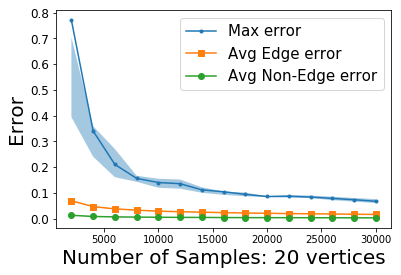

Total time: 00:01:16 


In [29]:
start = time.time()
results_1_gnp = simulate(weightsA, weightsB, numCascades_step, numCascades_mult, numPath, verbose = True)

plotExp1(results_1_gnp, N, 'gnp', numCascades_step, numCascades_mult)

end = time.time()
print "\x1b[31mTotal time:", time.strftime("%H:%M:%S", time.gmtime(end - start)), "\x1b[0m"

In [30]:
# import dill
# dill.dump_session('notebook_env_degree50.db')
# dill.load_session('notebook_env_exp5.db')

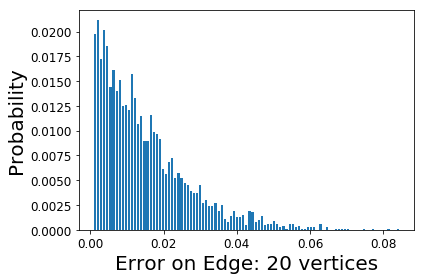

In [31]:
# EXPERIMENT 2: 
# Histogram of absolute error, 100 bins.

plotExp2(results_1_gnp, N,'gnp')

[10 12 14 16 19]
('Total Edges', 100)
('Degrees', DegreeView({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10, 16: 10, 17: 10, 18: 10, 19: 10}))
('Min Degrees', 10)
('Total Edges', 100)
('Degrees', DegreeView({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10, 16: 10, 17: 10, 18: 10, 19: 10}))
('Min Degrees', 10)
numVertices 20 numEdges A 200 numEdges B 200
numpath 1
# 2000 max X  0.151 max Y  0.186 max  0.491 avg edge  0.084 avg nonedge  0.035
# 4000 max X  0.106 max Y  0.113 max  0.603 avg edge  0.056 avg nonedge  0.023
# 6000 max X  0.101 max Y  0.09 max  0.302 avg edge  0.045 avg nonedge  0.019
# 8000 max X  0.083 max Y  0.08 max  1.064 avg edge  0.038 avg nonedge  0.017
# 10000 max X  0.07 max Y  0.074 max  0.586 avg edge  0.035 avg nonedge  0.015
# 12000 max X  0.06 max Y  0.069 max  0.505 avg edge  0.031 avg nonedge  0.014
# 14000 max X  0.053 m

/Users/jessicahoffmann/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


# 2000 max X  0.141 max Y  0.181 max  1.0 avg edge  0.125 avg nonedge  0.069
# 4000 max X  0.093 max Y  0.127 max  0.237 avg edge  0.053 avg nonedge  0.021
# 6000 max X  0.061 max Y  0.073 max  0.493 avg edge  0.042 avg nonedge  0.017
# 8000 max X  0.065 max Y  0.065 max  0.22 avg edge  0.038 avg nonedge  0.014
# 10000 max X  0.061 max Y  0.057 max  0.202 avg edge  0.035 avg nonedge  0.013
# 12000 max X  0.051 max Y  0.052 max  0.139 avg edge  0.031 avg nonedge  0.011
# 14000 max X  0.045 max Y  0.049 max  0.121 avg edge  0.028 avg nonedge  0.01
# 16000 max X  0.047 max Y  0.047 max  0.133 avg edge  0.026 avg nonedge  0.009
# 18000 max X  0.046 max Y  0.041 max  0.123 avg edge  0.025 avg nonedge  0.008
# 20000 max X  0.048 max Y  0.05 max  0.117 avg edge  0.024 avg nonedge  0.008
numpath 7
# 2000 max X  0.141 max Y  0.164 max  1.169 avg edge  0.109 avg nonedge  0.049
# 4000 max X  0.1 max Y  0.114 max  0.308 avg edge  0.057 avg nonedge  0.026
# 6000 max X  0.088 max Y  0.087 max  0.424

# 14000 max X  0.066 max Y  0.079 max  0.139 avg edge  0.029 avg nonedge  0.012
# 16000 max X  0.051 max Y  0.064 max  0.111 avg edge  0.027 avg nonedge  0.01
# 18000 max X  0.043 max Y  0.064 max  0.097 avg edge  0.024 avg nonedge  0.009
# 20000 max X  0.042 max Y  0.05 max  0.105 avg edge  0.024 avg nonedge  0.008
numpath 6
# 2000 max X  0.139 max Y  0.16 max  0.762 avg edge  0.083 avg nonedge  0.036
# 4000 max X  0.086 max Y  0.101 max  0.474 avg edge  0.056 avg nonedge  0.024
# 6000 max X  0.066 max Y  0.079 max  0.229 avg edge  0.043 avg nonedge  0.018
# 8000 max X  0.054 max Y  0.068 max  0.274 avg edge  0.037 avg nonedge  0.017
# 10000 max X  0.055 max Y  0.067 max  0.231 avg edge  0.033 avg nonedge  0.014
# 12000 max X  0.051 max Y  0.062 max  0.191 avg edge  0.029 avg nonedge  0.013
# 14000 max X  0.05 max Y  0.056 max  0.145 avg edge  0.028 avg nonedge  0.012
# 16000 max X  0.05 max Y  0.059 max  0.122 avg edge  0.026 avg nonedge  0.011
# 18000 max X  0.057 max Y  0.065 max  

# 6000 max X  0.075 max Y  0.088 max  0.266 avg edge  0.047 avg nonedge  0.024
# 8000 max X  0.079 max Y  0.096 max  0.295 avg edge  0.043 avg nonedge  0.022
# 10000 max X  0.066 max Y  0.078 max  0.389 avg edge  0.038 avg nonedge  0.021
# 12000 max X  0.059 max Y  0.068 max  0.274 avg edge  0.035 avg nonedge  0.018
# 14000 max X  0.056 max Y  0.061 max  0.219 avg edge  0.033 avg nonedge  0.016
# 16000 max X  0.056 max Y  0.064 max  0.162 avg edge  0.03 avg nonedge  0.015
# 18000 max X  0.049 max Y  0.055 max  0.159 avg edge  0.027 avg nonedge  0.014
# 20000 max X  0.051 max Y  0.056 max  0.128 avg edge  0.026 avg nonedge  0.013
numpath 6
# 2000 max X  0.152 max Y  0.15 max  0.697 avg edge  0.079 avg nonedge  0.045
# 4000 max X  0.105 max Y  0.12 max  1.824 avg edge  0.057 avg nonedge  0.036
# 6000 max X  0.082 max Y  0.098 max  0.428 avg edge  0.047 avg nonedge  0.026
# 8000 max X  0.068 max Y  0.093 max  0.233 avg edge  0.039 avg nonedge  0.021
# 10000 max X  0.076 max Y  0.094 max  

# 18000 max X  0.044 max Y  0.055 max  0.127 avg edge  0.029 avg nonedge  0.013
# 20000 max X  0.044 max Y  0.053 max  0.128 avg edge  0.028 avg nonedge  0.014
numpath 5
# 2000 max X  0.168 max Y  0.212 max  1.594 avg edge  0.149 avg nonedge  0.118
# 4000 max X  0.112 max Y  0.142 max  0.84 avg edge  0.084 avg nonedge  0.054
# 6000 max X  0.085 max Y  0.1 max  0.33 avg edge  0.051 avg nonedge  0.028
# 8000 max X  0.088 max Y  0.094 max  0.539 avg edge  0.044 avg nonedge  0.022
# 10000 max X  0.077 max Y  0.082 max  0.249 avg edge  0.039 avg nonedge  0.022
# 12000 max X  0.083 max Y  0.079 max  0.198 avg edge  0.035 avg nonedge  0.02
# 14000 max X  0.078 max Y  0.078 max  0.156 avg edge  0.032 avg nonedge  0.019
# 16000 max X  0.071 max Y  0.061 max  0.148 avg edge  0.03 avg nonedge  0.017
# 18000 max X  0.06 max Y  0.058 max  0.116 avg edge  0.027 avg nonedge  0.014
# 20000 max X  0.049 max Y  0.058 max  0.113 avg edge  0.026 avg nonedge  0.013
numpath 6
# 2000 max X  0.154 max Y  0.16

# 12000 max X  0.076 max Y  0.08 max  0.169 avg edge  0.039 avg nonedge  0.0
# 14000 max X  0.079 max Y  0.074 max  0.182 avg edge  0.036 avg nonedge  0.0
# 16000 max X  0.075 max Y  0.076 max  0.147 avg edge  0.033 avg nonedge  0.0
# 18000 max X  0.064 max Y  0.065 max  0.15 avg edge  0.03 avg nonedge  0.0
# 20000 max X  0.059 max Y  0.059 max  0.137 avg edge  0.028 avg nonedge  0.0
numpath 5
# 2000 max X  0.149 max Y  0.175 max  0.71 avg edge  0.164 avg nonedge  0.0
# 4000 max X  0.099 max Y  0.119 max  0.878 avg edge  0.108 avg nonedge  0.0
# 6000 max X  0.084 max Y  0.118 max  0.835 avg edge  0.081 avg nonedge  0.0
# 8000 max X  0.071 max Y  0.098 max  0.451 avg edge  0.05 avg nonedge  0.0
# 10000 max X  0.059 max Y  0.075 max  0.392 avg edge  0.045 avg nonedge  0.0
# 12000 max X  0.05 max Y  0.073 max  0.312 avg edge  0.038 avg nonedge  0.0
# 14000 max X  0.045 max Y  0.062 max  0.22 avg edge  0.035 avg nonedge  0.0
# 16000 max X  0.047 max Y  0.055 max  0.203 avg edge  0.033 avg 

<Figure size 432x288 with 0 Axes>

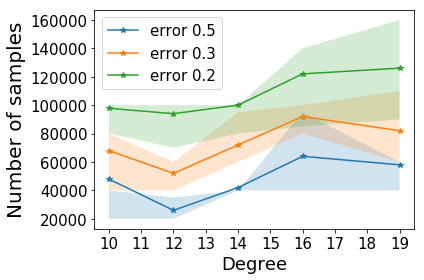

In [32]:
# EXPERIMENT 3:
# Vary the density of edges

start = time.time()
N = 20 # must be even
numCascades_step = N*100
numCascades_mult = 10
numPath = 10
numDegree = 5

# Multiple edge density
deg = np.linspace(10, N-1, num = numDegree, dtype = int)
print deg
res = []
for d1 in deg:
    weightsA, weightsB = createGraph(N, typ = 'reg', degree = d1)
    results = simulate(weightsA, weightsB, numCascades_step, numCascades_mult, numPath, verbose = True)
    res.append(results)
    end = time.time()
    print "\x1b[31mTotal time until degree", d1, ":", time.strftime("%H:%M:%S", time.gmtime(end - start)), "\x1b[0m"

plotExp3({deg[i]: res[i] for i in range(numDegree)}, N, 
         typ = 'reg', scale = deg, error_tol = [0.5, 0.3, 0.2])
end = time.time()
print "\x1b[31mTotal time:", time.strftime("%H:%M:%S", time.gmtime(end - start)), "\x1b[0m"